In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "rbc_phase"
ood = "1"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

RBC Dataset V.2 => All pateints
Dataset split type train, image type: phase


Loaded 1462 images
RBC Dataset V.2 => All pateints
Dataset split type val, image type: phase


Loaded 493 images
RBC Dataset V.2 => All pateints
Dataset split type test, image type: phase


Loaded 493 images
RBC Dataset V.2 => All pateints
Dataset split type test, image type: phase


Loaded 928 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1 duvrach6


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                         | 0/12 [00:00<?, ?it/s]

  8%|██████████▊                                                                                                                      | 1/12 [00:00<00:10,  1.02it/s]

 17%|█████████████████████▌                                                                                                           | 2/12 [00:01<00:05,  1.99it/s]

 25%|████████████████████████████████▎                                                                                                | 3/12 [00:01<00:03,  2.86it/s]

 33%|███████████████████████████████████████████                                                                                      | 4/12 [00:01<00:02,  3.60it/s]

 42%|█████████████████████████████████████████████████████▊                                                                           | 5/12 [00:01<00:01,  4.19it/s]

 50%|████████████████████████████████████████████████████████████████▌                                                                | 6/12 [00:01<00:01,  4.65it/s]

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 7/12 [00:01<00:00,  5.01it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 8/12 [00:02<00:00,  5.27it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 9/12 [00:02<00:00,  5.46it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 10/12 [00:02<00:00,  5.60it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 11/12 [00:02<00:00,  5.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  6.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.30it/s]

train - OK


  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:00<00:01,  2.38it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:00<00:00,  3.66it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:00<00:00,  4.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.19it/s]

val - OK


  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:00<00:01,  2.46it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:00<00:00,  3.74it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:00<00:00,  4.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.37it/s]

test InD - OK


  0%|                                                                                                                                          | 0/8 [00:00<?, ?it/s]

 12%|████████████████▎                                                                                                                 | 1/8 [00:00<00:02,  2.46it/s]

 25%|████████████████████████████████▌                                                                                                 | 2/8 [00:00<00:01,  3.75it/s]

 38%|████████████████████████████████████████████████▊                                                                                 | 3/8 [00:00<00:01,  4.51it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 4/8 [00:00<00:00,  4.99it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████▎                                                | 5/8 [00:01<00:00,  5.30it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 6/8 [00:01<00:00,  5.50it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 7/8 [00:01<00:00,  5.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]

test OoD - OK


  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]

  1%|█▎                                                                                                                              | 1/100 [00:00<00:14,  6.95it/s]

  2%|██▌                                                                                                                             | 2/100 [00:00<00:14,  6.96it/s]

  3%|███▊                                                                                                                            | 3/100 [00:00<00:13,  6.97it/s]

  4%|█████                                                                                                                           | 4/100 [00:00<00:13,  6.98it/s]

  5%|██████▍                                                                                                                         | 5/100 [00:00<00:13,  6.98it/s]

  6%|███████▋                                                                                                                        | 6/100 [00:00<00:13,  6.98it/s]

  7%|████████▉                                                                                                                       | 7/100 [00:01<00:13,  6.98it/s]

  8%|██████████▏                                                                                                                     | 8/100 [00:01<00:13,  6.99it/s]

  9%|███████████▌                                                                                                                    | 9/100 [00:01<00:13,  6.99it/s]

 10%|████████████▋                                                                                                                  | 10/100 [00:01<00:12,  6.99it/s]

 11%|█████████████▉                                                                                                                 | 11/100 [00:01<00:12,  6.99it/s]

 12%|███████████████▏                                                                                                               | 12/100 [00:01<00:12,  6.99it/s]

 13%|████████████████▌                                                                                                              | 13/100 [00:01<00:12,  6.99it/s]

 14%|█████████████████▊                                                                                                             | 14/100 [00:02<00:12,  6.99it/s]

 15%|███████████████████                                                                                                            | 15/100 [00:02<00:12,  6.99it/s]

 16%|████████████████████▎                                                                                                          | 16/100 [00:02<00:12,  6.99it/s]

 17%|█████████████████████▌                                                                                                         | 17/100 [00:02<00:11,  6.99it/s]

 18%|██████████████████████▊                                                                                                        | 18/100 [00:02<00:11,  6.99it/s]

 19%|████████████████████████▏                                                                                                      | 19/100 [00:02<00:11,  6.99it/s]

 20%|█████████████████████████▍                                                                                                     | 20/100 [00:02<00:11,  6.99it/s]

 21%|██████████████████████████▋                                                                                                    | 21/100 [00:03<00:11,  6.99it/s]

 22%|███████████████████████████▉                                                                                                   | 22/100 [00:03<00:11,  6.99it/s]

 23%|█████████████████████████████▏                                                                                                 | 23/100 [00:03<00:11,  6.99it/s]

 24%|██████████████████████████████▍                                                                                                | 24/100 [00:03<00:10,  7.00it/s]

 25%|███████████████████████████████▊                                                                                               | 25/100 [00:03<00:10,  7.00it/s]

 26%|█████████████████████████████████                                                                                              | 26/100 [00:03<00:10,  6.99it/s]

 27%|██████████████████████████████████▎                                                                                            | 27/100 [00:03<00:10,  6.99it/s]

 28%|███████████████████████████████████▌                                                                                           | 28/100 [00:04<00:10,  6.99it/s]

 29%|████████████████████████████████████▊                                                                                          | 29/100 [00:04<00:10,  6.99it/s]

 30%|██████████████████████████████████████                                                                                         | 30/100 [00:04<00:10,  6.99it/s]

 31%|███████████████████████████████████████▎                                                                                       | 31/100 [00:04<00:09,  6.99it/s]

 32%|████████████████████████████████████████▋                                                                                      | 32/100 [00:04<00:09,  6.99it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [00:04<00:09,  6.99it/s]

 34%|███████████████████████████████████████████▏                                                                                   | 34/100 [00:04<00:09,  6.99it/s]

 35%|████████████████████████████████████████████▍                                                                                  | 35/100 [00:05<00:09,  6.99it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 36/100 [00:05<00:09,  7.00it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 37/100 [00:05<00:09,  7.00it/s]

 38%|████████████████████████████████████████████████▎                                                                              | 38/100 [00:05<00:08,  6.99it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 39/100 [00:05<00:08,  6.99it/s]

 40%|██████████████████████████████████████████████████▊                                                                            | 40/100 [00:05<00:08,  6.99it/s]

 41%|████████████████████████████████████████████████████                                                                           | 41/100 [00:05<00:08,  6.99it/s]

 42%|█████████████████████████████████████████████████████▎                                                                         | 42/100 [00:06<00:08,  6.99it/s]

 43%|██████████████████████████████████████████████████████▌                                                                        | 43/100 [00:06<00:08,  6.99it/s]

 44%|███████████████████████████████████████████████████████▉                                                                       | 44/100 [00:06<00:08,  6.99it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                     | 45/100 [00:06<00:07,  6.99it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                    | 46/100 [00:06<00:07,  6.99it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                   | 47/100 [00:06<00:07,  6.99it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 48/100 [00:06<00:07,  6.99it/s]

 49%|██████████████████████████████████████████████████████████████▏                                                                | 49/100 [00:07<00:07,  6.99it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                               | 50/100 [00:07<00:07,  6.99it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                              | 51/100 [00:07<00:07,  6.99it/s]

 52%|██████████████████████████████████████████████████████████████████                                                             | 52/100 [00:07<00:06,  6.99it/s]

 53%|███████████████████████████████████████████████████████████████████▎                                                           | 53/100 [00:07<00:06,  6.99it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [00:07<00:06,  6.99it/s]

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 55/100 [00:07<00:06,  6.99it/s]

 56%|███████████████████████████████████████████████████████████████████████                                                        | 56/100 [00:08<00:06,  6.99it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 57/100 [00:08<00:06,  6.99it/s]

 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 58/100 [00:08<00:06,  6.99it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 59/100 [00:08<00:05,  6.99it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 60/100 [00:08<00:05,  6.99it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 61/100 [00:08<00:05,  6.99it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 62/100 [00:08<00:05,  7.00it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 63/100 [00:09<00:05,  6.99it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 64/100 [00:09<00:05,  6.99it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 65/100 [00:09<00:05,  6.99it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 66/100 [00:09<00:04,  6.99it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████                                          | 67/100 [00:09<00:04,  6.99it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 68/100 [00:09<00:04,  7.00it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 69/100 [00:09<00:04,  7.00it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 70/100 [00:10<00:04,  7.00it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 71/100 [00:10<00:04,  7.00it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 72/100 [00:10<00:04,  7.00it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 73/100 [00:10<00:03,  7.00it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 74/100 [00:10<00:03,  7.00it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 75/100 [00:10<00:03,  6.99it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 76/100 [00:10<00:03,  7.00it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 77/100 [00:11<00:03,  7.00it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 78/100 [00:11<00:03,  7.00it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 79/100 [00:11<00:03,  7.00it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 80/100 [00:11<00:02,  7.00it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 81/100 [00:11<00:02,  6.99it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 82/100 [00:11<00:02,  6.99it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 83/100 [00:11<00:02,  6.99it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 84/100 [00:12<00:02,  6.99it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 85/100 [00:12<00:02,  6.99it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 86/100 [00:12<00:02,  6.99it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 87/100 [00:12<00:01,  6.99it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 88/100 [00:12<00:01,  6.99it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 89/100 [00:12<00:01,  6.99it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 90/100 [00:12<00:01,  6.99it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 91/100 [00:13<00:01,  6.99it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 92/100 [00:13<00:01,  7.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [00:13<00:01,  6.99it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 94/100 [00:13<00:00,  6.99it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 95/100 [00:13<00:00,  6.99it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [00:13<00:00,  6.99it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97/100 [00:13<00:00,  6.99it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [00:14<00:00,  6.99it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:14<00:00,  6.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.99it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(1462, 1, 64, 64) (1462, 512) (1462, 3584) (1462, 1, 64, 64) (1462,)
(493, 1, 64, 64) (493, 512) (493, 3584) (493, 1, 64, 64) (493,)
(493, 1, 64, 64) (493, 512) (493, 3584) (493, 1, 64, 64) (493,)
(928, 1, 64, 64) (928, 512) (928, 3584) (928, 1, 64, 64) (928,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create tsne embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

WARNING clustering 1421 points to 37 centroids: please provide at least 1443 training points


(493, 2) (928, 2)


WARNING clustering 1421 points to 37 centroids: please provide at least 1443 training points


(493, 2) (928, 2)


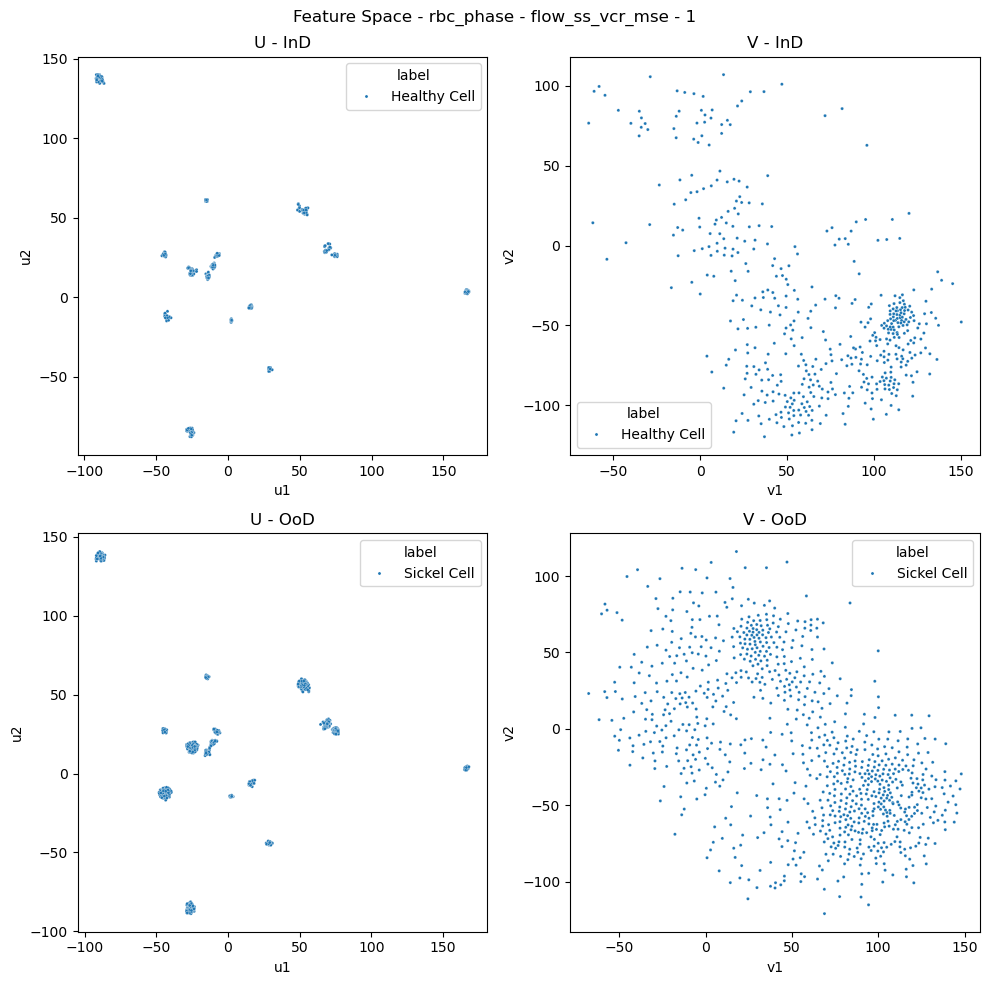

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:00<00:00,  3.79it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:00<00:00,  5.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:00<00:00,  6.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.29it/s]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:00<00:00,  6.47it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:00<00:00,  6.50it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:00<00:00,  6.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]

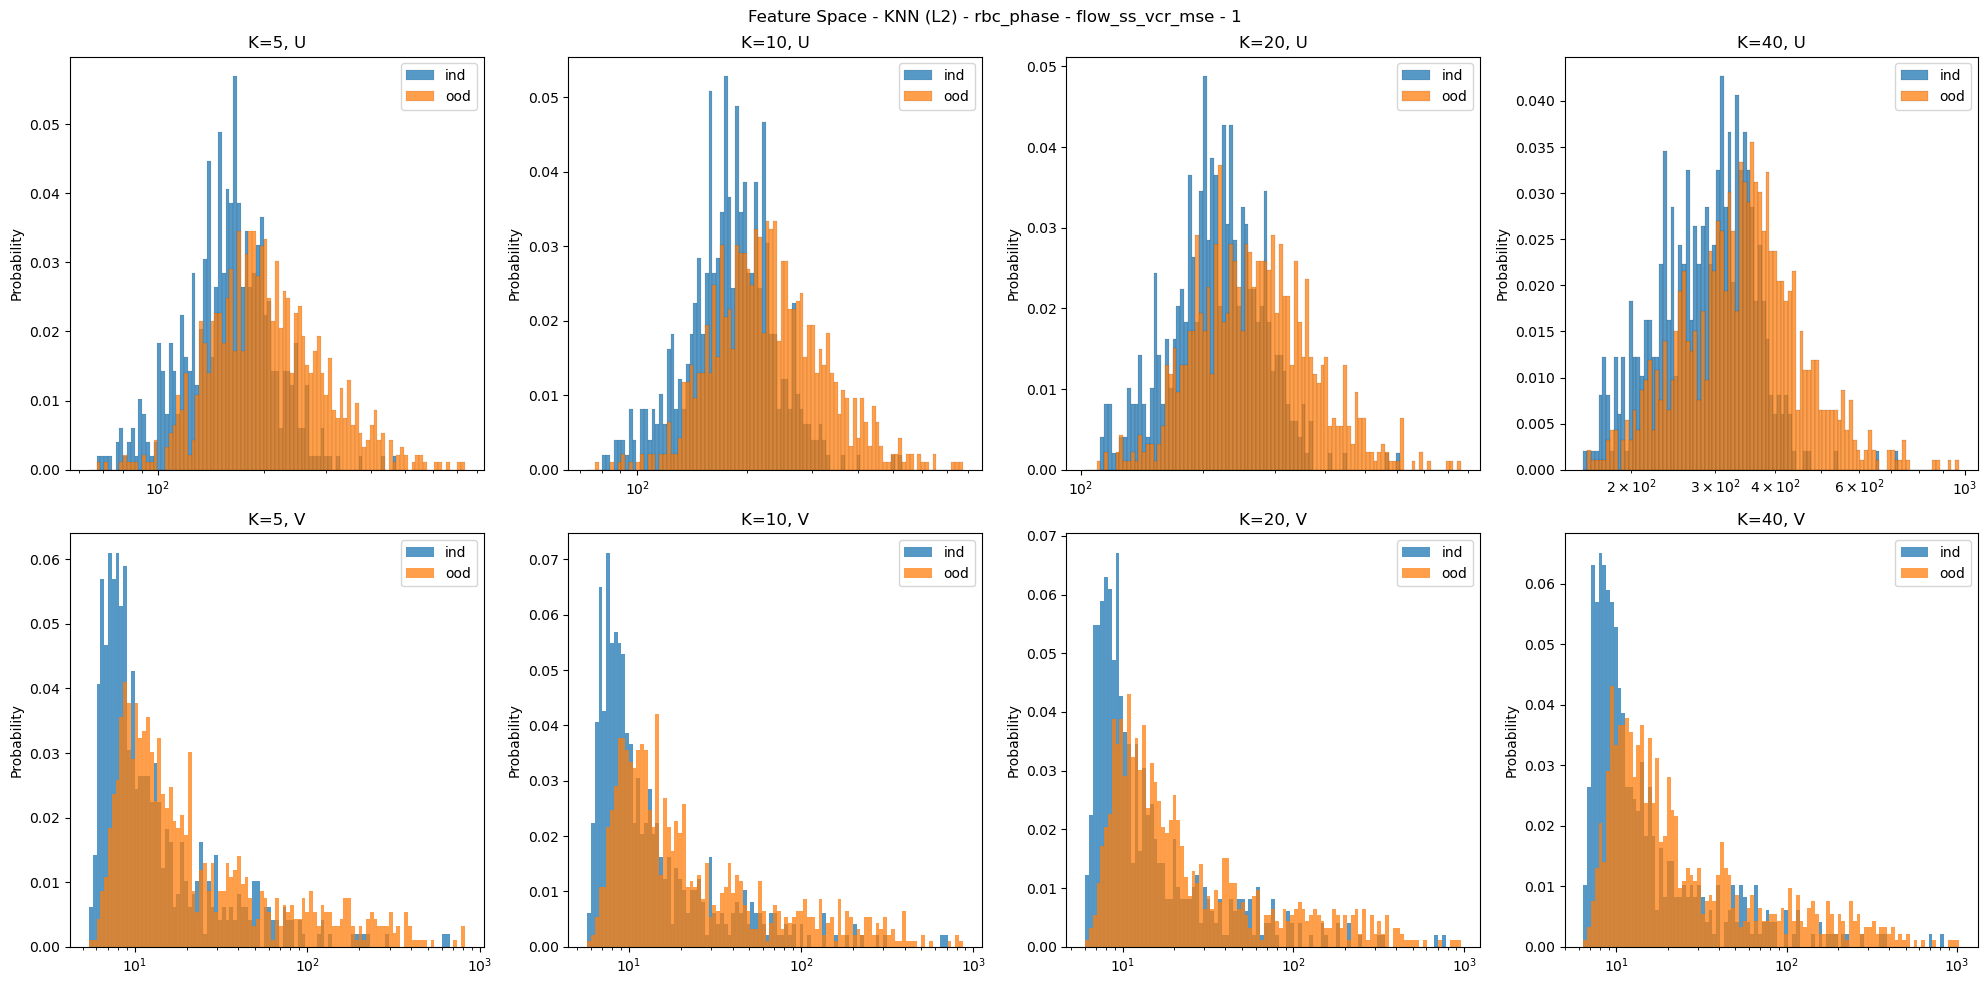

In [13]:
# plot knn to val data in feature space (L2)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:00<00:00,  8.34it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:00<00:00,  8.25it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:00<00:00,  8.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:00<00:00,  6.64it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:00<00:00,  6.64it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:00<00:00,  4.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]

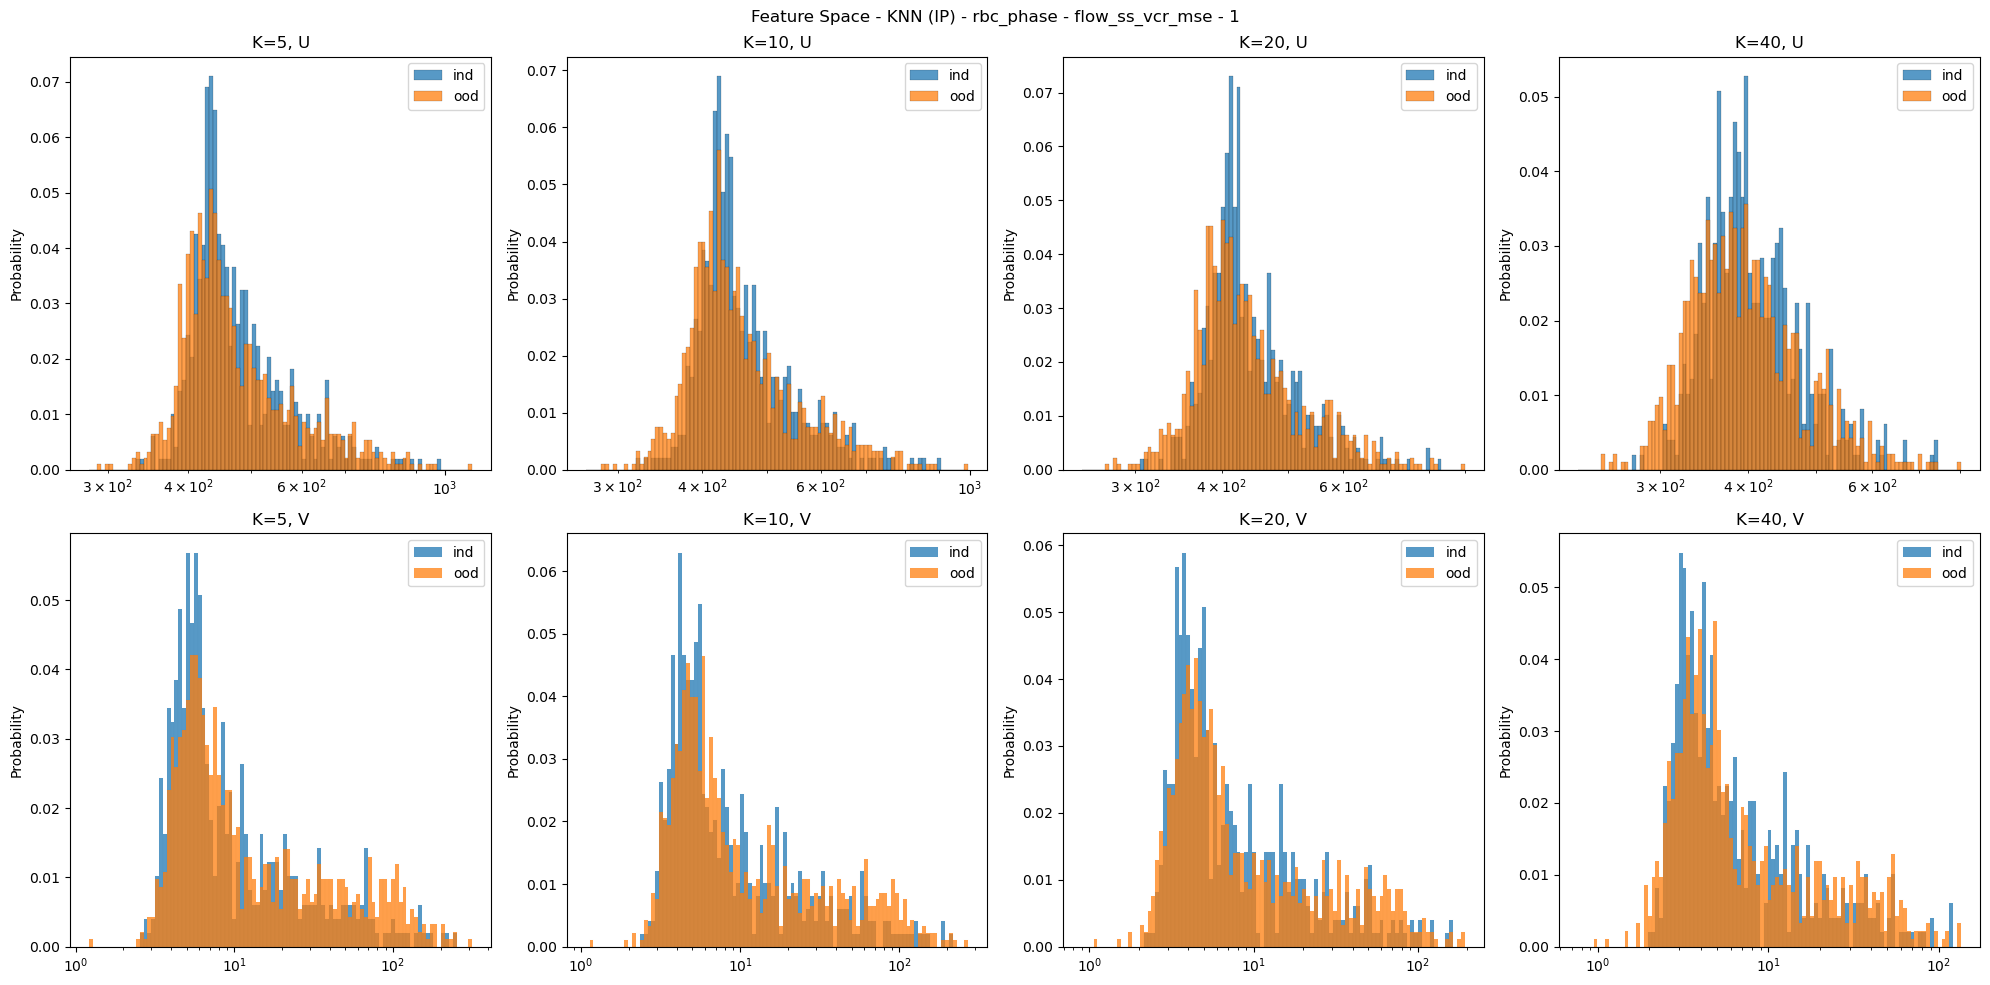

In [14]:
# plot knn to val data in feature space (IP)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

23.504948 2.227572 4.261977 3.418565
23.353893 1.6671593 4.151781 2.6249242
23.462791 1.990168 4.195576 3.1140344
24.261652 2.8793898 5.8586903 4.5852804
31.687569 0.7831943 58.340775 0.7110851


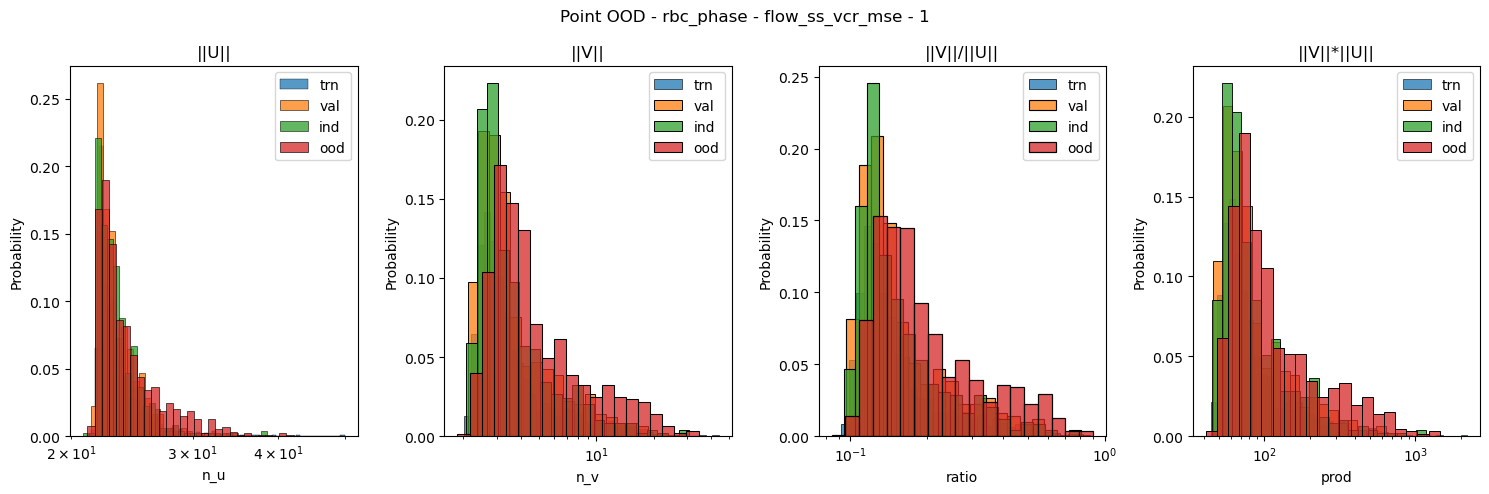

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


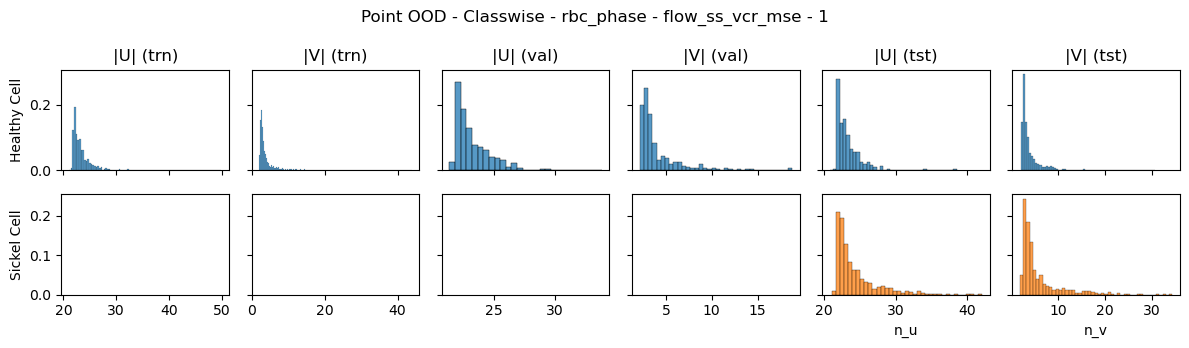

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

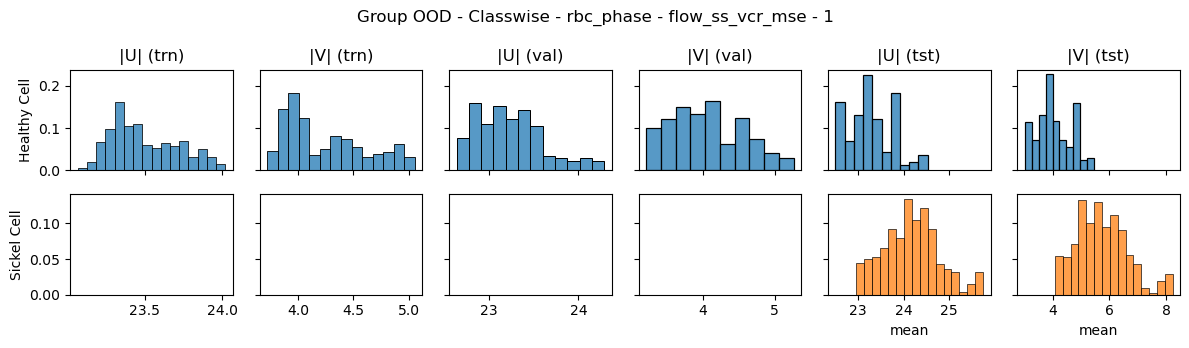

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

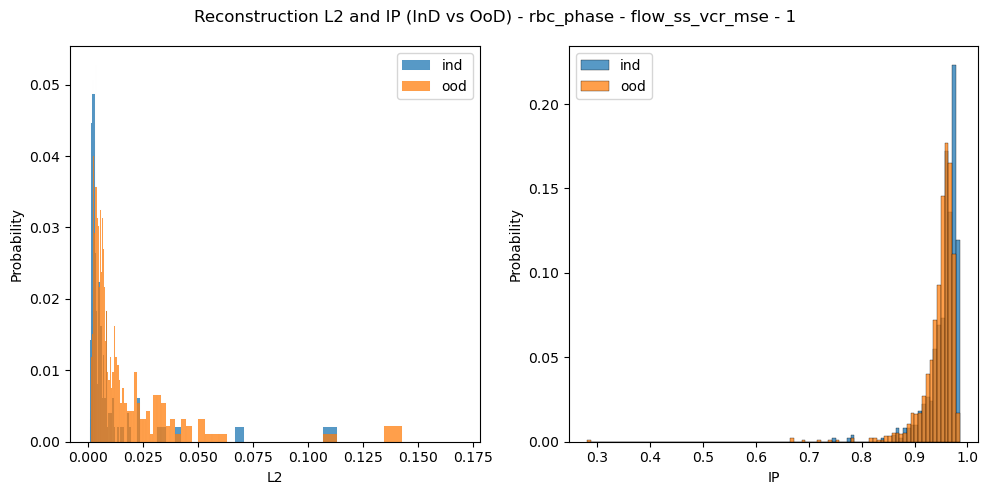

In [20]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()